## Read dataset and create a graph

In [1]:
import re
import random
import pandas as pd
import numpy as np
import networkx as nx
from itertools import count
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

In [2]:
version = '0.1.3'
file_name = 'novels_' + version + '.csv'

In [202]:
df = pd.read_csv(file_name, na_values='NaN')
G = nx.Graph()

# Add nodes
def get_node_label(genres):
    return {'genre': random.choice(genres)}

df['genres'] = df['genres'].str.replace("['\[\]]", '', regex=True).str.split(", ")

nodes = [(t[0], get_node_label(t[1])) for t in df[['id', 'genres']].values]
G.add_nodes_from(nodes)

# Add edges
edge_attr = 'recommended_series_ids'
df_edge = df.loc[~df[edge_attr].isnull()].copy()
df_edge[edge_attr] = df_edge.loc[:, edge_attr].str.strip('[]').str.split(',')

edges = []
for source_node, node_edges in df_edge[['id', edge_attr]].values:
    for target_node in node_edges:
        if int(target_node) in G.nodes():
            edges.append((source_node, int(target_node)))
G.add_edges_from(edges)

print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 13582
Number of edges: 33798


In [203]:
# Remove nodes in small clusters
remove = [n for c in nx.connected_components(G) for n in c if len(c) < 10]
G.remove_nodes_from(remove)

# Select a random sample of nodes
start_node = random.choice(list(G.nodes()))
nodes = nx.bfs_tree(G, start_node, reverse=False, depth_limit=3, sort_neighbors=None).nodes()
G.remove_nodes_from(G.nodes() - nodes)

print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 291
Number of edges: 740


In [204]:
# Get color dictionary
genres = df['genres'].explode().unique()
mapping = dict(zip(sorted(genres), count()))
colors = [mapping[G.nodes[n]['genre']] for n in G.nodes()]

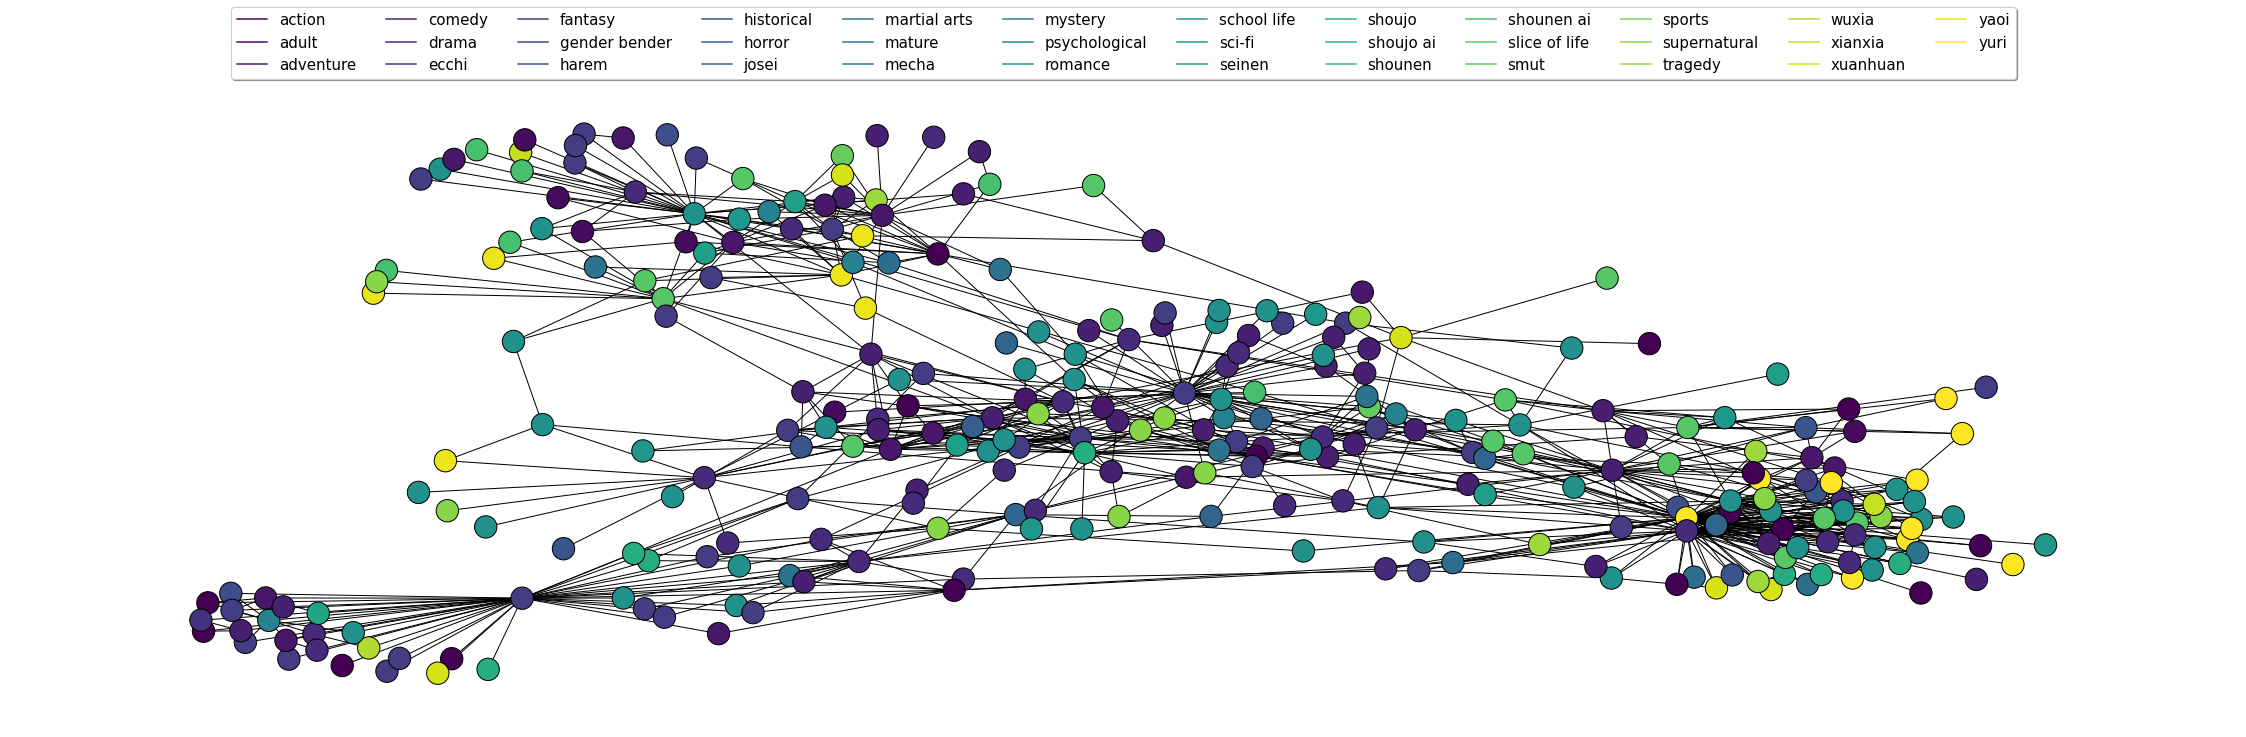

In [211]:
fig = plt.figure(figsize=(40, 12)) 
ax = fig.add_subplot(1,1,1)

# Colors and legend inforamtion
cmap = plt.cm.viridis
cnorm = matplotlib.colors.Normalize(vmin=0, vmax=max(mapping.values()))
sm = ScalarMappable(cnorm, cmap)
for label in mapping:
    ax.plot([0],[0], color=sm.to_rgba(mapping[label]),label=label)

# Draw
nx.draw_spring(G, node_color=colors, node_size=500, with_labels=False, cmap=plt.cm.viridis, edgecolors='black', ax=ax)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=12, fancybox=True, shadow=True, fontsize=15)
plt.show() 
fig.savefig('graph_new3.svg') 

In [212]:
df

,id,name,assoc_names,original_language,authors,genres,tags,start_year,licensed,original_publisher,...,activity_month_rank,activity_all_time_rank,on_reading_lists,reading_list_month_rank,reading_list_all_time_rank,rating,rating_votes,related_series_ids,recommended_series_ids,recommendation_list_ids
0,56152,A Former Child Soldier Who Uses a Magic Sword ...,['A Former Child Soldier Who Uses a Magic Swor...,japanese,"['hasekura mondo', '支倉文度']","[action, adventure, fantasy, romance, seinen]","['adapted to manga', 'calm protagonist', 'enem...",2018,False,shinkigensha,...,1359,7632,521,1437,8470,3.5,24,NaN,NaN,[1382]
1,58160,A Lifelong Love Affair At Work,['평생직장에서 사내연애'],korean,['새벽한강'],"[action, adventure, romance, shounen ai]","['magic', 'office romance']",2022,False,ridibooks,...,3256,13595,132,5158,12646,5.0,2,NaN,NaN,"[60769, 50877, 48872]"
2,32558,A Saint Who Was Adopted by the Grand Duke,['대공가에 입양된 성녀님'],korean,"['songiba', '송이바']","[drama, fantasy, romance, tragedy]","['adopted protagonist', 'age progression', 'be...",2020,NaN,feelyeon management,...,149,971,6808,161,660,4.3,159,NaN,"[30160, 32548, 42318, 37111, 38870, 49722]","[60604, 60442, 60245, 60093, 59587]"
3,57315,A World where Mercenary Men are Called Goddesses,['傭兵の男が女神と呼ばれる世界'],japanese,['野原 耳子'],"[action, adult, adventure, drama, fantasy, smu...","['appearance different from actual age', 'brot...",2020,False,alpha polis,...,454,6896,673,894,7533,4.4,48,NaN,NaN,"[60607, 57754, 57353, 50615, 50089]"
4,57610,"About Touma-kun, Who Wants to Spend His Time Q...","[""Shizuka ni sugoshitai Touma-kun ga gakkou no...",japanese,['おとら@二作品書籍化'],"[comedy, romance, school life, slice of life]","['appearance changes', 'beautiful female lead'...",2021,NaN,syosetu,...,150,6229,509,172,8559,4.2,49,NaN,NaN,[35611]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13587,2023,Yu-Gi-Oh! Duel Monsters: Pyramid of Light,['Yu-Gi-Oh! Pyramid of Light'],japanese,"['junki takegami', 'masahiro hikokubo']","[fantasy, school life, shounen, supernatural]","['card games', 'male protagonist']",NaN,False,NaN,...,2000,13443,46,13863,13550,1.8,6,NaN,NaN,NaN
13588,2035,Zettainaru Kodokusha,"['The Isolator', 'Zettainaru Isolator', '絶対ナル孤...",japanese,"['kawahara reki', '川原 礫']","[action, adventure, sci-fi]","['adapted to manga', 'aliens', 'death of loved...",2014,True,ascii media works,...,2000,11975,277,13866,10761,3.4,28,NaN,NaN,"[35581, 31872, 6674]"
13589,7143,Zodiac Witches: Juuni Seiza no Majo,['ゾディアック・ウィッチーズ 十二星座の魔女'],japanese,['shumon yuu'],"[action, comedy, fantasy, romance, school life]",[],2013,False,fujimi shobo,...,2000,13154,175,3750,12037,4.5,4,NaN,NaN,NaN
13590,4369,ZoNe,NaN,japanese,['funky cupcakes'],"[action, adventure, drama, fantasy, romance]","['demons', 'dragons', 'elves', 'gods', 'magic'...",NaN,False,NaN,...,8737,13518,76,13867,13323,3.8,8,NaN,NaN,NaN
